#### 1. Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score


%matplotlib inline

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### 2 . Reading the csv file and putting it into 'df' object

In [2]:
df = pd.read_csv('telecom_churn_data.csv')
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


#### 3. Data Preparation

##### 3.1. Derive New Metrics 
Derive New Metrics such as the Subscriber Growth in terms of plans, i.e.,whether there was increase in terms of recharge amount in terms of talktime and net usage, and the IsChurned - whether the customer churned or not

In [3]:
df[['total_rech_amt_8','total_rech_amt_9','total_rech_data_8','total_rech_data_9','total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']] = df[['total_rech_amt_8','total_rech_amt_9','total_rech_data_8','total_rech_data_9','total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].fillna(0)

In [4]:
def issubgrowth_tt(df):

    if (df['total_rech_amt_8'] < df['total_rech_amt_9']):
        return 1
    else:
        return 0
    
df['issubgrowth_tt'] = df.apply(issubgrowth_tt, axis = 1)

def issubgrowth_data(df):

    if (df['total_rech_data_8'] < df['total_rech_data_9']):
        return 1
    else:
        return 0
    
df['issubgrowth_data'] = df.apply(issubgrowth_data, axis = 1)

def ischurned(df):
    if (df['total_ic_mou_9'] == 0 or df['total_og_mou_9'] == 0) and (df['vol_2g_mb_9'] == 0 or df['vol_3g_mb_9'] == 0):
        return 1
    else:
        return 0
    
df['churned'] = df.apply(ischurned, axis = 1)

In [5]:
df['churned'].value_counts()

0    86593
1    13406
Name: churned, dtype: int64

In [6]:
#Drop september month related columns
sept_cols = []
for i in df.columns:
    if '9' in i:
        sept_cols.append(i)
df.drop(sept_cols,axis=1,inplace=True)

In [7]:
#Drop one valued columns
df.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'],axis=1,inplace=True)

##### 3.2. Filter out high percentile values

In [8]:
imputer = IterativeImputer(max_iter=10, verbose=0)

In [9]:
df[['total_rech_amt_6','total_rech_amt_7','total_rech_data_6','total_rech_data_7','av_rech_amt_data_6','av_rech_amt_data_7']] = pd.DataFrame(data=imputer.fit_transform(df[['total_rech_amt_6','total_rech_amt_7','total_rech_data_6','total_rech_data_7','av_rech_amt_data_6','av_rech_amt_data_7']])[0:,0:],
             columns = ['total_rech_amt_6','total_rech_amt_7','total_rech_data_6','total_rech_data_7','av_rech_amt_data_6','av_rech_amt_data_7'])

In [10]:
df['rech_amt_good'] = df['total_rech_amt_6']+ df['total_rech_amt_7']  + (df['total_rech_data_6']*df['av_rech_amt_data_6']) + (df['total_rech_data_7']*df['av_rech_amt_data_7']) 

In [11]:
#The high percentile values are 30K
len(df[df['rech_amt_good'] > df['rech_amt_good'].describe(percentiles =[0.50,0.70,1.0])['70%']]) 

30000

In [12]:
df= df[df['rech_amt_good'] > df['rech_amt_good'].describe(percentiles =[0.50,0.70,1.0])['70%']]

In [13]:
df = df.reset_index()
df.drop(['index'],axis=1,inplace=True)

##### 3.3. Missing Data Imputation 

In [14]:
#Find columns which has values 0,1,NaNs and fill NaNs with zeroes
less_val_cols = []
for i in df.columns:
    if len(df[i].value_counts()) <= 2:
        less_val_cols.append(i)
df[less_val_cols] = df[less_val_cols].fillna(0)

In [15]:
#Impute for categorical variables 
object_cols = []
for i in df.select_dtypes(include='object').columns:
    object_cols.append(i)
df[object_cols] = df[object_cols].fillna('01/01/1900')
object_cols.append('churned')

In [16]:
df[list(set(df.columns) - set(object_cols))] = pd.DataFrame(data=imputer.fit_transform(df[list(set(df.columns) - set(object_cols))]),
             columns = df[list(set(df.columns) - set(object_cols))].columns)

In [17]:
#There are no null values now
df.isnull().sum(axis=0).sort_values(ascending=False)

rech_amt_good               0
og_others_6                 0
loc_ic_t2t_mou_8            0
loc_ic_t2t_mou_7            0
loc_ic_t2t_mou_6            0
total_og_mou_8              0
total_og_mou_7              0
total_og_mou_6              0
og_others_8                 0
og_others_7                 0
spl_og_mou_8                0
std_ic_mou_7                0
spl_og_mou_7                0
spl_og_mou_6                0
isd_og_mou_8                0
isd_og_mou_7                0
isd_og_mou_6                0
std_og_mou_8                0
std_og_mou_7                0
std_og_mou_6                0
loc_ic_t2m_mou_6            0
loc_ic_t2m_mou_7            0
loc_ic_t2m_mou_8            0
loc_ic_t2f_mou_6            0
std_ic_t2o_mou_8            0
std_ic_t2o_mou_7            0
std_ic_t2o_mou_6            0
std_ic_t2f_mou_8            0
std_ic_t2f_mou_7            0
std_ic_t2f_mou_6            0
                           ..
isd_ic_mou_8                0
isd_ic_mou_7                0
isd_ic_mou

#### 4 . EDA

##### 4.1. Univariate Distributions

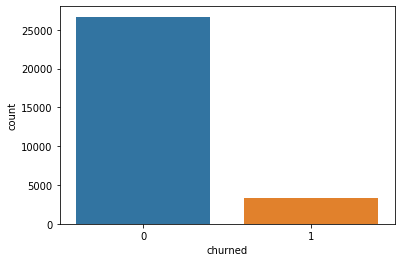

In [18]:
sns.countplot(x='churned', data = df)

With the above graph we can identify the churning pattern and that most of the users are not churned

##### 4.2. Bivariate Distributions

[(0, 35145.834)]

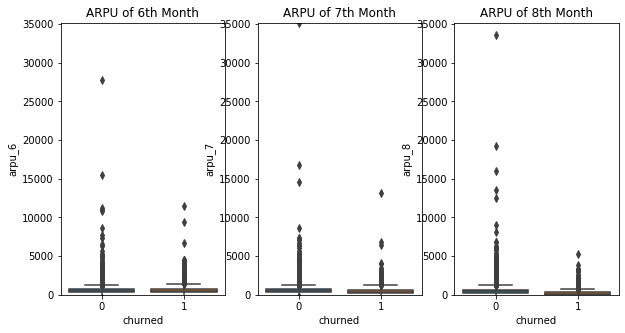

In [19]:
#Average Revenue Per User Usage patterns
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('ARPU of 6th Month')
sns.boxplot(x='churned', y='arpu_6',data = df).set(ylim=(0, np.max(df[['arpu_6','arpu_7','arpu_8']]).max()))

plt.subplot(1, 3, 2)
plt.title('ARPU of 7th Month')
sns.boxplot(x='churned', y='arpu_7',data = df).set(ylim=(0, np.max(df[['arpu_6','arpu_7','arpu_8']]).max()))

plt.subplot(1, 3, 3)
plt.title('ARPU of 8th Month')
sns.boxplot(x='churned', y='arpu_8',data = df).set(ylim=(0, np.max(df[['arpu_6','arpu_7','arpu_8']]).max()))

[(0, 14007.34)]

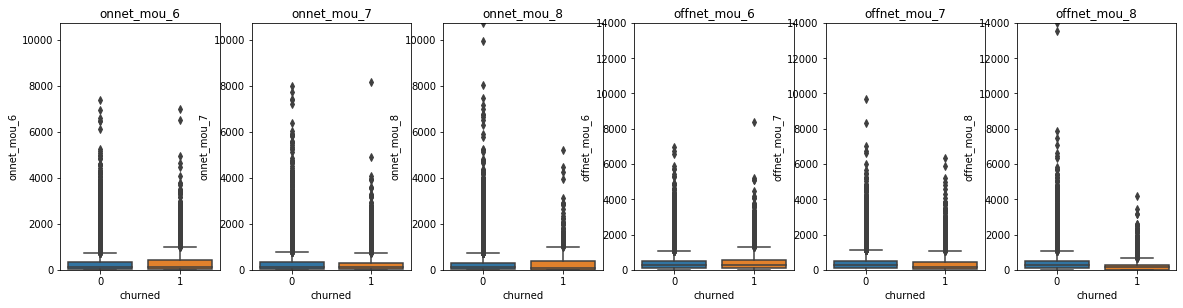

In [20]:
# OnNet usage patterns - Calls within the same network
plt.figure(figsize=(20, 10))
plt.subplot(2, 6, 1)
plt.title('onnet_mou_6')
sns.boxplot(x='churned', y='onnet_mou_6',data = df).set(ylim=(0, np.max(df[['onnet_mou_6','onnet_mou_7','onnet_mou_8']]).max()))

plt.subplot(2, 6, 2)
plt.title('onnet_mou_7')
sns.boxplot(x='churned', y='onnet_mou_7',data = df).set(ylim=(0, np.max(df[['onnet_mou_6','onnet_mou_7','onnet_mou_8']]).max()))

plt.subplot(2, 6, 3)
plt.title('onnet_mou_8')
sns.boxplot(x='churned', y='onnet_mou_8',data = df).set(ylim=(0, np.max(df[['onnet_mou_6','onnet_mou_7','onnet_mou_8']]).max()))

# OnNet usage patterns - Calls to other networks
plt.subplot(2, 6, 4)
plt.title('offnet_mou_6')
sns.boxplot(x='churned', y='offnet_mou_6',data = df).set(ylim=(0, np.max(df[['offnet_mou_6','offnet_mou_7','offnet_mou_8']]).max()))

plt.subplot(2, 6, 5)
plt.title('offnet_mou_7')
sns.boxplot(x='churned', y='offnet_mou_7',data = df).set(ylim=(0, np.max(df[['offnet_mou_6','offnet_mou_7','offnet_mou_8']]).max()))

plt.subplot(2, 6, 6)
plt.title('offnet_mou_8')
sns.boxplot(x='churned', y='offnet_mou_8',data = df).set(ylim=(0, np.max(df[['offnet_mou_6','offnet_mou_7','offnet_mou_8']]).max()))



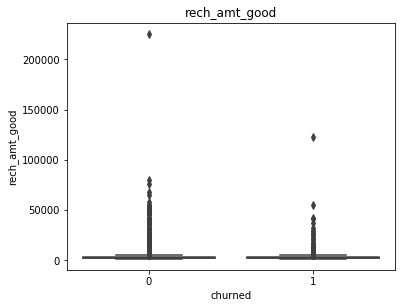

In [21]:
# Recharge Amount patterns
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.title('rech_amt_good')
sns.boxplot(x='churned', y='rech_amt_good',data = df)

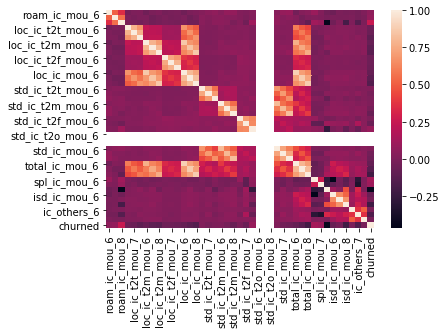

In [22]:
#Incoming Call patterns
ic_cols = []
for i in df.columns:
    if "ic" in i:
        ic_cols.append(i)
ic_cols.append('churned')

sns.heatmap(df[ic_cols].corr())

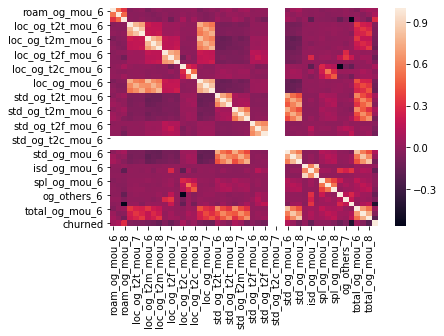

In [23]:
#Outgoing Call patterns
og_cols = []
for i in df.columns:
    if "og" in i:
        og_cols.append(i)
og_cols.append('churned')

sns.heatmap(df[og_cols].corr())

##### 4.3. Removing Outliers

In [24]:
def cap_outliers(df, k=3):
    outliers = pd.DataFrame() 
    newdf = df
    for col in df.columns:
        if(str(df[col].dtype)!='object' and str(df[col].dtype)!='bool'):
            data_mean, data_std = df[col].mean(), df[col].std()
            lower, upper = data_mean - data_std*k, data_mean + data_std*k
            outliers[col] = df[((df[col] < lower) | (df[col] > upper))][col]
    return outliers

In [25]:
imputed_df = cap_outliers(df)

In [26]:
#Data Loss due to imputation 
print(len(imputed_df))

#This is tolerable, thus removing the outliers
df = df.iloc[list(set(df.index) - set(imputed_df.index)),:]

332


In [27]:
#The remaining data set
df = df.reset_index()
df.drop(['index'],axis=1,inplace=True)
df.shape

(29668, 169)

#### 5. Predictive Model

##### 5.1 Aggregating the Categorical Columns

In [28]:
object_cols = []
for col in df.columns:
        if(str(df[col].dtype)=='object'):
            object_cols.append(col)

for i in object_cols:
    by_date = df.groupby(i)
    df1 = pd.DataFrame(by_date.churned.mean()).reset_index()
    df1.columns = [i,'mean_churn_'+i[-6:]+'']
    df= df.merge(df1,how='right', left_on=i, right_on=i)
    df.drop(i,axis=1,inplace=True)

In [29]:
df.head(2)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,issubgrowth_tt,issubgrowth_data,churned,rech_amt_good,mean_churn_rech_6,mean_churn_rech_7,mean_churn_rech_8,mean_churn_data_6,mean_churn_data_7,mean_churn_data_8
0,7.001051e+09,429.023,190.704,255.114,71.03,45.03,76.66,262.73,49.24,92.08,...,0.0,0.0,0,1531.888422,0.105898,0.084573,0.103821,0.115624,0.121894,0.14347
1,7.000721e+09,424.904,382.716,569.310,77.73,110.58,94.74,408.51,325.23,488.48,...,1.0,0.0,0,2004.551906,0.105898,0.084573,0.103821,0.115624,0.121894,0.14347


##### 5.2 Splitting Data into Training and Test Sets

In [30]:
# Putting feature variable to X
X = df.drop(['churned','mobile_number'],axis=1)

# Putting response variable to y
y = df['churned']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

#### 5.3 PCA

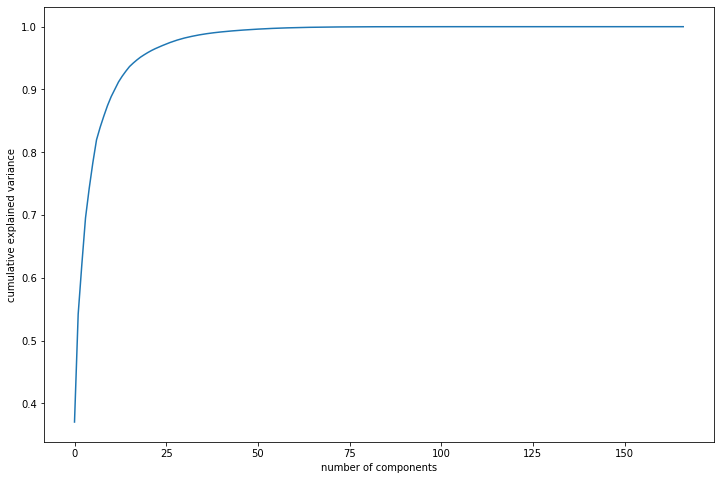

In [31]:
### PCA on the train data
#Importing the PCA module

pca = PCA(svd_solver='randomized', random_state=42)

#Doing the PCA on the train data
pca.fit(X_train)

#Finding the components
pca.components_

colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})

#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

About 30 components are able to identify 99% of the cumulative variance 

max corr: 0.017243094831543824 , min corr:  -0.010448321888605486


(8901, 30)

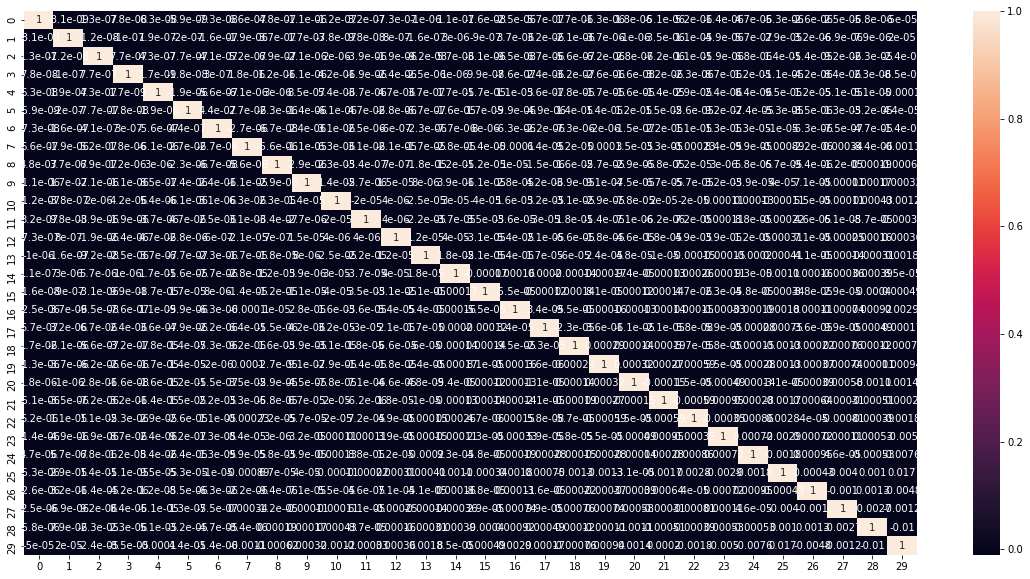

In [32]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
pca_final = IncrementalPCA(n_components=30)

#### Basis transformation - getting the data onto our PCs

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

#### Creating correlation matrix for the principal components - we expect little to no correlation
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)


#Applying selected components to the test data - 16 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

No Correlation between PCA - Orthogonality persists

#### 5.4 Logistic Regression

In [33]:
#### Applying a logistic regression on our Principal Components

#Training the model on the train data
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)


#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))


'0.89'

#### 5.5 Hyper parameter tuning for Logistic Regression

In [34]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'C': [1, 10, 100, 1000]}]

    

In [35]:
# set up GridSearchCV()
model_cv = GridSearchCV(learner_pca, 
                        hyper_params, 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)    

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid=[{'C': [1, 10, 100, 1000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=1)

In [36]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',model_cv.best_score_,'using',model_cv.best_params_)

We can get accuracy of 0.9233880676072616 using {'C': 1000}


#### 5.6 Random Forest Classifier

In [37]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# Making predictions
predictions = rfc.predict(X_test)
print(accuracy_score(y_test,predictions))

0.9425907201438041


#### 5.7 Hyper parameter tuning for Random Forest Classifier

In [38]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  9.2min finished


We can get accuracy of 0.9206914816776617 using {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 300}


In [39]:
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=8,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=100)

# fit
rfc.fit(X_train,y_train)

# predict
predictions = rfc.predict(X_test)
print(accuracy_score(y_test,predictions))

0.9345017413773733


RFC is better in terms of accuracy

#### 6. Solution

#### 6.1 Important Feature

In [ ]:
logreg = LogisticRegression()
rfe = RFE(logreg, 30)             # running RFE with 30 variables as output
rfe = rfe.fit(X_train, y_train)
X_train.columns[rfe.support_]

The above list gives the top 30 features to consider

#### 6.2  ROC Curve

In [ ]:
y_pred=logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### 6.3 Insights 

Business recommendations: 
In order to stop the user switching to a different network, the aformentioned factors must be clearly monitored for every user in the action period the 8th month. 
Plans which gives more usage for less user rates must be advertised to the user to increase the usage rates eventually. 
More benefits to the users like an added subscription, like Amazon Prime could be suggested to the user.
    Signal Issues should be correctly identified in users who have more usages.w